# Fitting Pure component data

The purpose of this notebook is to show how fit to vapor pressure data of pure component, volume translation for a cubic EoS and also influence paramaters used in square gradient theory.

In [2]:
import numpy as np
from phasepy import component

In [3]:
#Experimental Saturation Data of water obtained from NIST
#Saturation Temperature in Kelvin
Tsat = np.array([290., 300., 310., 320., 330., 340., 350., 360., 370., 380.]) 

#Saturation Pressure in bar
Psat = np.array([0.0192  , 0.035368, 0.062311, 0.10546 , 0.17213 , 0.27188 ,
       0.41682 , 0.62194 , 0.90535 , 1.2885  ])

#Saturated Liquid density in mol/cm3
rhol = np.array([0.05544 , 0.055315, 0.055139, 0.054919, 0.054662, 0.054371,
       0.054049, 0.053698, 0.053321, 0.052918]) 

#Interfacial Tension in mN/m
tension = np.array([73.21 , 71.686, 70.106, 68.47 , 66.781, 65.04 , 63.248, 61.406,
       59.517, 57.581]) 

Antoine Parameters can be fitted using Temperature and Saturation pressure experimental data, as the objective function can have several local minimun an initial guess can be provided (optional).

In [4]:
#Fitting Antoine Coefficients
from phasepy.fit import fit_ant

Ant = fit_ant(Tsat, Psat)
#Objection function value, Antoine Parameters
5.1205342479858257e-05, [1.34826650e+01, 5.02634690e+03, 9.07664231e-04]

#Optionally an initial guess for the parameters can be passed to the function

Ant = fit_ant(Tsat, Psat, x0 = [11, 3800, -44])
#Objection function value, Antoine Parameters
2.423780448316938e-07,[ 11.6573823 , 3800.11357063,  -46.77260501]

(2.423780448316938e-07, [11.6573823, 3800.11357063, -46.77260501])

When using Peng-Robinson-Stryjek-Vera EoS, the parameters for the $\alpha$ function can optimized.

In [5]:
#Fitting ksv for PRSV EoS
from phasepy.fit import fit_ksv

#parameters of pure component obtained from DIPPR
name = 'water'
Tc = 647.13 #K
Pc = 220.55 #bar
Zc = 0.229
Vc = 55.948 #cm3/mol
w = 0.344861
pure = component(name = name, Tc = Tc, Pc = Pc, Zc = Zc, Vc = Vc, w = w)

ksv = fit_ksv(pure, Tsat, Psat)
#Objection function value, ksv Parameters
1.5233471126821199e-10, [ 0.87185176, -0.06621339]

(1.5233471126821199e-10, [0.87185176, -0.06621339])

When using a cubic EoS the volume can be traslated as suggested by Péneloux. In phase it is possible to optimize this parameter with liquid density experimental data as can be seen.

In [6]:
from phasepy import prsveos
from phasepy.fit import fit_vt

#Defining the component with the optimized alpha parameters
pure = component(name = name, Tc = Tc, Pc = Pc, Zc = Zc, Vc = Vc, w = w,
                ksv = [ 0.87185176, -0.06621339] )

vt = fit_vt(pure, prsveos, Tsat, Psat, rhol)
#Objetive function and volume translation
0.001270834833817397, 3.46862174

(0.001270834833817397, 3.46862174)

So far saturation pressure data and liquid density has been fitted, when using a cubic equation state it is possible to fit the influence parameter used in square gradient theory for interfacial description. In phasepy the influece parameter can be fitted using a Polynomial respect the temperature.

Beware that the value of the influence parameter depends of the value of densities predicted by the EoS so a volume traslation will modify the value of this parameter.

In [7]:
from phasepy.fit import fit_cii
#Defining the component with the volume traslation parameter.
pure = component(name = name, Tc = Tc, Pc = Pc, Zc = Zc, Vc = Vc, w = w,
                ksv = [ 0.87185176, -0.06621339], c =  3.46862174)

eos = prsveos(pure, volume_translation = False)
cii = fit_cii(tension, Tsat, eos, order = 2)
#fitted influence parameter polynomial
[2.06553362e-26, 2.64204784e-23, 4.10320513e-21]
eos = prsveos(pure, volume_translation = True)
cii = fit_cii(tension, Tsat, eos, order = 2)
#fitted influence parameter polynomial with volume translation
[2.74008872e-26, 1.23088986e-23, 3.05681188e-21]

[2.74008872e-26, 1.23088986e-23, 3.05681188e-21]

Finally you can compare the fitted values against the exeprimental data.

In [8]:
import matplotlib.pyplot as plt
from phasepy.sgt import sgt_pure

water =  component(name = name, Tc = Tc, Pc = Pc, Zc = Zc, Vc = Vc, w = w,
                ksv = [ 0.87185176, -0.06621339], c =  3.46862174,
                   cii = [2.74008872e-26, 1.23088986e-23, 3.05681188e-21])

eos = prsveos(water, volume_translation = True)

P = np.zeros_like(Psat)
vl = np.zeros_like(rhol)
vv = np.zeros_like(rhol)
ten = np.zeros_like(tension)

n = len(Tsat)
#computing the saturation pressure and the volumes of the phases
for i in range(n):
    P[i], vl[i], vv[i] = eos.psat(Tsat[i])

rho_l = 1/vl
rho_v = 1/vv
#computing the interfacial tension
for i in range(n):
    ten[i] = sgt_pure(rho_v[i], rho_l[i], Tsat[i], P[i], eos)

Text(0, 0.5, 'IFT / mN m$^{-1}$')

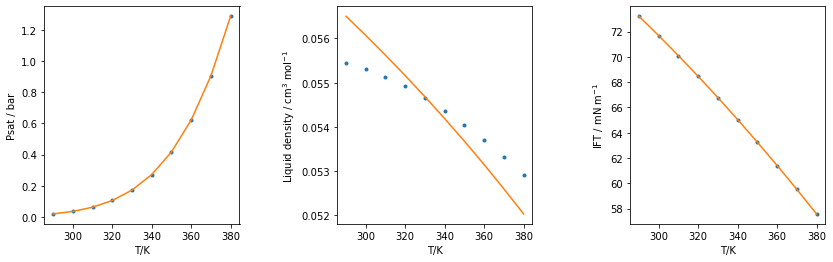

In [9]:
fig = plt.figure(figsize = (14, 4))
fig.subplots_adjust(wspace = 0.5)
ax1 = fig.add_subplot(131)
ax1.plot(Tsat, Psat, '.')
ax1.plot(Tsat, P)
ax1.set_xlabel('T/K')
ax1.set_ylabel('Psat / bar')

ax2 = fig.add_subplot(132)
ax2.plot(Tsat, rhol, '.')
ax2.plot(Tsat, rho_l)
ax2.set_xlabel('T/K')
ax2.set_ylabel(r'Liquid density / cm$^3$ mol$^{-1}$')

ax3 = fig.add_subplot(133)
ax3.plot(Tsat, tension, '.')
ax3.plot(Tsat, ten)
ax3.set_xlabel('T/K')
ax3.set_ylabel('IFT / mN m$^{-1}$')


For further information please also check [official documentation](https://phasepy.readthedocs.io/), or just try:

```function?```